In [ ]:
from textblob import TextBlob
import numpy as np
import requests
import pandas as pd
import os
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
#nltk.download('stopwords')

my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_call(call, bigrams=False):
    call = call.lower() # lower case
    call = re.sub('['+my_punctuation + ']+', ' ', call) # strip punctuation
    call = re.sub('\s+', ' ', call) #remove double spacing
    call = re.sub('([0-9]+)', '', call) # remove numbers
    #call_token_list = [word for word in call.split(' ')
    #                        if word not in my_stopwords] # remove stopwords
    #call_token_list = [word_rooter(word) if '#' not in word else word
    #                    for word in call_token_list] # apply word rooter
    
    call_token_list = [word_rooter(word) if '#' not in word else word
                        for word in call.split(' ')] # modify word rooter to skip stop word removal
    
    if bigrams:
        call_token_list = call_token_list+[call_token_list[i]+'_'+call_token_list[i+1]
                                            for i in range(len(call_token_list)-1)]
    call = ' '.join(call_token_list)
    return call


sentiment_polarity = []
sentiment_subjectivity = []
ID = []

for sector in ['energy', 'health', 'tech']:
    i=0
    # Quarterly call transcripts are saved in "directory"
    directory = r'/Users/pgoff/Google Drive/1_Learning_Python/Goff_Repo/Classification/' + sector + '_transcripts'
    transcripts = [trans for trans in os.listdir(directory) if (trans.find(".txt") + 1)]

    for file in transcripts:
        path = './' + sector + '_transcripts/' + file 
        fname = file
        with open(path, 'r') as file:
            BagOfWords = file.read().replace('\n', '')
            BagOfWords = clean_call(BagOfWords)
            sentiment_call = TextBlob(BagOfWords)
            sentiment_polarity.append(sentiment_call.sentiment[0])
            sentiment_subjectivity.append(sentiment_call.sentiment[1])     
            ID.append(fname[:-4])
        i+=1
        if i%100 == 0:
            print(f'Sector is {sector}. File {i} of {len(transcripts)}')

            
df = pd.DataFrame(list(zip(sentiment_polarity, sentiment_subjectivity, ID)),
               columns =['sentiment_polarity', 'sentiment_subjectivity', 'id'])
df.to_pickle("./sentiment.pkl")

In [425]:
import yfinance as yf
from datetime import datetime
from datetime import date
from datetime import timedelta
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [580]:
df = pd.read_pickle("./tech_tickers.pkl").drop_duplicates(subset='id') # Given more time, investigate these duplicates
print("Number of unique companies: ", df.tick.nunique())
df.shape

Number of unique companies:  350


(4264, 24)

In [581]:
health_df = pd.read_pickle("./health_tickers.pkl").drop_duplicates(subset='id') 
print("Number of unique companies: ", health_df.tick.nunique())
health_df.shape

Number of unique companies:  364


(3613, 19)

In [582]:
sent_df = pd.read_pickle("./sentiment.pkl")

df = pd.read_pickle("./tech_tickers.pkl").drop_duplicates(subset='id') # Given more time, investigate these duplicates

# Appending health data  
health_df = pd.read_pickle("./health_tickers.pkl").drop_duplicates(subset='id') # Given more time, investigate these duplicates
df = df.append(health_df)

df = df.merge(sent_df, on='id', how='inner')
df['call_q'] = pd.to_numeric(df['call_q'], errors='coerce') # Given more time, investigate why these non-integer quarters were recorded
df.dropna(subset=['call_q', 'slope_pre'], inplace=True)
df.shape

(7683, 26)

In [583]:
print("Number of unique companies: ", df.tick.nunique())

df['open_ratio'] = df.Open_post/df.Open_pre

df = df.drop(['Open_post', 'High_post', 'Low_post', 'Close_post', 'Volume_post', 'Dividends_post', 'Stock Splits_post', 
              'Dividends_post', 'Stock Splits_post'], axis=1)

df['open_ratio'].describe()

Number of unique companies:  697


count    7683.000000
mean        1.003389
std         0.121193
min         0.342238
25%         0.942996
50%         1.001233
75%         1.058106
max         2.944140
Name: open_ratio, dtype: float64

0    0.722244
1    0.277756
Name: open_up5, dtype: float64


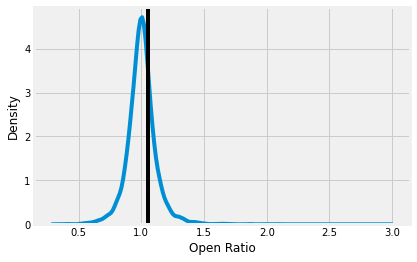

In [584]:
# generate binary indicator at the 75th percentile of increases. This establishes a class-imbalance that will need to be fixed later. 
df['open_up5'] = 0
df.loc[df['open_ratio'] >= 1.05, 'open_up5'] = 1

# What is the imbalance? Histogram of ratios with line
print(df.open_up5.value_counts(normalize=True))

sns.kdeplot(data=df, x='open_ratio');
plt.axvline(1.05, color='black');
plt.xlabel("Open Ratio")
plt.savefig('feature_density.png');

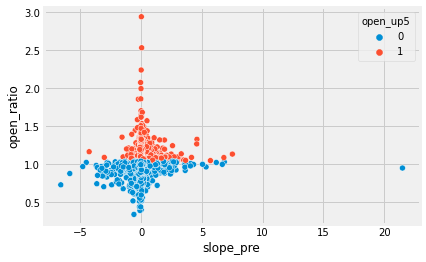

In [585]:
# Check scatterplot to identify any correlation between proportional increases and other metrics.
sns.scatterplot(data=df, x='slope_pre', y='open_ratio', hue='open_up5');

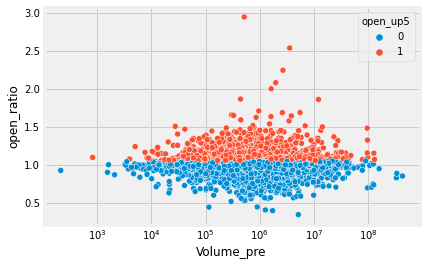

In [586]:
splot = sns.scatterplot(data=df, x='Volume_pre', y='open_ratio', hue='open_up5')
splot.set(xscale="log");

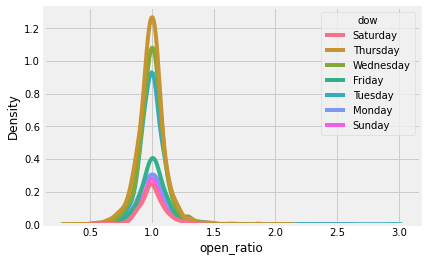

In [587]:
df['date2'] = df['date'].apply(pd.Timestamp)
df['dow'] = df.date2.dt.day_name()
df['year'] = df.date2.dt.year

sns.kdeplot(data=df, x='open_ratio', hue='dow');
df = pd.get_dummies(df, columns=['dow'])

In [432]:
print(f"95th percentile of observations per stock: {df.groupby('tick').open_ratio.agg('count').quantile(q=0.95)}")
print(f"75th percentile of observations per stock: {df.groupby('tick').open_ratio.agg('count').quantile(q=0.75)}")
print(f"25th percentile of observations per stock:  {df.groupby('tick').open_ratio.agg('count').quantile(q=0.25)}")
print(f" 5th percentile of observations per stock:  {df.groupby('tick').open_ratio.agg('count').quantile(q=0.05)}")
print(f"Minimum:  {df.groupby('tick').open_ratio.agg('count').min()}")
print(f"Maximum:  {df.groupby('tick').open_ratio.agg('count').max()}")

95th percentile of observations per stock: 19.0
75th percentile of observations per stock: 11.0
25th percentile of observations per stock:  10.0
 5th percentile of observations per stock:  2.0
Minimum:  1
Maximum:  355


## <font color='yellow'> Baselining </font>
Initial model with volume, dividend, year, and day of week.

In [434]:
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import xgboost as xgb
import imblearn.over_sampling

# metrics imports
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

## Constructing test-train data sets. 
Using most recent year as test data. 

In [588]:
X_train = df[['Volume_pre', 'Dividends_pre', 'year', 'dow_Monday', 'dow_Tuesday', 
              'dow_Wednesday', 'dow_Thursday', 'dow_Friday', 'dow_Saturday', 'slope_pre', 'sentiment_polarity',
              'sentiment_subjectivity', 'call_q']][df.year<2021]
y_train = df['open_up5'][df.year<2021]

X_test = df[['Volume_pre', 'Dividends_pre', 'year', 'dow_Monday', 'dow_Tuesday', 
              'dow_Wednesday', 'dow_Thursday', 'dow_Friday', 'dow_Saturday', 'slope_pre', 'sentiment_polarity',
              'sentiment_subjectivity', 'call_q']][df.year==2021]
y_test = df['open_up5'][df.year==2021]

In [591]:
print("Number of unique companies: ", df[df.year==2021].tick.nunique())
df[df.year==2021].shape

Number of unique companies:  656


(1278, 30)

# Alternate Test Set

In [524]:
df2 = pd.read_pickle("./energy_tickers.pkl")
df2['call_q'] = pd.to_numeric(df2['call_q'], errors='coerce') # Given more time, investigate why these non-integer quarters were recorded
df2['date2'] = df2['date'].apply(pd.Timestamp)
df2['dow'] = df2.date2.dt.day_name()
df2['year'] = df2.date2.dt.year
df2 = pd.get_dummies(df2, columns=['dow'])
df2['open_ratio'] = df2.Open_post/df2.Open_pre
df2['open_up5'] = 0
df2.loc[df2['open_ratio'] >= 1.05, 'open_up5'] = 1
df2 = df2.merge(sent_df, on='id', how='inner')
df2.dropna(subset=['call_q', 'slope_pre'], inplace=True)
df2.shape

X_test2 = df2[['Volume_pre', 'Dividends_pre', 'year', 'dow_Monday', 'dow_Tuesday', 
              'dow_Wednesday', 'dow_Thursday', 'dow_Friday', 'dow_Saturday', 'slope_pre', 'sentiment_polarity',
              'sentiment_subjectivity', 'call_q']]
y_test2 = df2['open_up5']

In [578]:
print("Number of unique companies: ", df2.tick.nunique())
df2.shape

Number of unique companies:  202


(2455, 37)

In [526]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Don't forget to standard scale your data for regularized regression
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Create the same polynomial features and apply the same scaler to test set
X_test_poly = poly.fit_transform(X_test)
X_test_poly_scaled = scaler.transform(X_test_poly)

X_test_poly2 = poly.fit_transform(X_test2)
X_test_poly_scaled2 = scaler.transform(X_test_poly2)

In [437]:
# Arrays play nicely with the crossfold validation
X, y = np.array(X_train_poly_scaled), np.array(y_train)

In [438]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1618)
cv_precision, cv_recall, cv_f1, cv_AUC = [], [], [], [] #collect the validation results 

for train_ind, val_ind in kf.split(X):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    m1_log = LogisticRegression(solver='liblinear')

    m1_log.fit(X_train, y_train)
    y_predict = m1_log.predict(X_val) 
    
    cv_precision.append(precision_score(y_val, y_predict))
    cv_recall.append(recall_score(y_val, y_predict))
    cv_f1.append(f1_score(y_val, y_predict))
    cv_AUC.append(roc_auc_score(y_val, m1_log.predict_proba(X_val)[:, 1]))

logcv_precision = np.mean(cv_precision)
logcv_recall = np.mean(cv_recall)
logcv_f1 = np.mean(cv_f1)
logcv_AUC = np.mean(cv_AUC)
    
print(f'Baseline Logistic Precision score: {np.mean(cv_precision):.3f}')
print(f'Baseline Logistic Recall score:    {np.mean(cv_recall):.3f}')
print(f'Baseline Logistic F1 score:        {np.mean(cv_f1):.3f}')
print(f'Baseline Logistic ROC AUC score:   {np.mean(cv_AUC):.3f}')

Baseline Logistic Precision score: 0.451
Baseline Logistic Recall score:    0.027
Baseline Logistic F1 score:        0.051
Baseline Logistic ROC AUC score:   0.585


## <font color='yellow'> Additional Models: </font> KNN

In [439]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1618)
cv_precision, cv_recall, cv_f1, cv_AUC = [], [], [], [] #collect the validation results 

for train_ind, val_ind in kf.split(X):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #KNN
    knn = KNeighborsClassifier(n_neighbors=5)

    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_val) 
    
    cv_precision.append(precision_score(y_val, y_predict))
    cv_recall.append(recall_score(y_val, y_predict))
    cv_f1.append(f1_score(y_val, y_predict))
    cv_AUC.append(roc_auc_score(y_val, m1_log.predict_proba(X_val)[:, 1]))

knncv_precision = np.mean(cv_precision)
knncv_recall = np.mean(cv_recall)
knncv_f1 = np.mean(cv_f1)
knncv_AUC = np.mean(cv_AUC)
    
print(f'Baseline knn Precision score: {np.mean(cv_precision):.3f}')
print(f'Baseline knn Recall score:    {np.mean(cv_recall):.3f}')
print(f'Baseline knn F1 score:        {np.mean(cv_f1):.3f}')
print(f'Baseline knn ROC AUC score:   {np.mean(cv_AUC):.3f}')

Baseline knn Precision score: 0.354
Baseline knn Recall score:    0.223
Baseline knn F1 score:        0.273
Baseline knn ROC AUC score:   0.608


## <font color='yellow'> Additional Models: </font> Random Forest
Starting with a random search for hyper-parameter tuning, then moving to a grid-search.

In [451]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)] # original showed 200; 255; 122

# Number of features to consider at every split
max_features = ['auto'] # output showed 'auto'; auto

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 16, num = 3)] # orig: np.linspace(10, 110, num = 11) - ouput showed 10; 9; 5
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15] # original showed 5; 10; 5

# Minimum number of samples required at each leaf node
min_samples_leaf = [3, 4, 5] # original: [1, 2, 4] - output showed 4; 4

# Method of selecting samples for training each tree
bootstrap = [True] # output showed true

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [452]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42,
                               scoring="f1", 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X, y)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 211,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [453]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [22, 24, 28, 32, 36], 
    'min_samples_leaf': [1, 2, 3], 
    'min_samples_split': [2, 3, 4], 
    'n_estimators': [6, 7, 8, 9, 10] 
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           scoring="f1",
                           cv = 3, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X, y)
rf_f1_best_params = grid_search.best_params_
grid_search.best_params_

Fitting 3 folds for each of 225 candidates, totalling 675 fits


{'bootstrap': True,
 'max_depth': 32,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 6}

In [454]:
# Repeating to check for optimization for AUC 
param_grid = {
    'bootstrap': [True],
    'max_depth': [22, 24, 28, 32, 36],  
    'min_samples_leaf': [1, 2, 3], 
    'min_samples_split': [2, 3, 4], 
    'n_estimators': [6, 7, 8, 9, 11, 14] 
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           scoring="roc_auc",
                           cv = 3, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X, y)
rf_roc_auc_best_params = grid_search.best_params_
grid_search.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits


{'bootstrap': True,
 'max_depth': 32,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 11}

In [455]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1618)
cv_precision, cv_recall, cv_f1, cv_AUC = [], [], [], [] #collect the validation results 

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    # Random Forest 
    rf = RandomForestClassifier()
    rf.set_params(**rf_f1_best_params)

    rf.fit(X_train, y_train)
    y_predict = rf.predict(X_val) 
    
    cv_precision.append(precision_score(y_val, y_predict))
    cv_recall.append(recall_score(y_val, y_predict))
    cv_f1.append(f1_score(y_val, y_predict))
    cv_AUC.append(roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1]))

rfcv_precision = np.mean(cv_precision)
rfcv_recall = np.mean(cv_recall)
rfcv_f1 = np.mean(cv_f1)
rfcv_AUC = np.mean(cv_AUC)

print(f'Baseline RF Precision score: {np.mean(cv_precision):.3f}')
print(f'Baseline RF Recall score:    {np.mean(cv_recall):.3f}')
print(f'Baseline RF F1 score:        {np.mean(cv_f1):.3f}')
print(f'Baseline RF ROC AUC score:   {np.mean(cv_AUC):.3f}')

Baseline RF Precision score: 0.335
Baseline RF Recall score:    0.181
Baseline RF F1 score:        0.235
Baseline RF ROC AUC score:   0.545


## <font color='yellow'> Additional Models: </font> ExtraTrees
Building from the grid-search from Random Forest

In [456]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [28, 30, 35, 40, 45], 
    'min_samples_leaf': [1, 2, 3], 
    'min_samples_split': [2, 3, 4], 
    'n_estimators': [6, 7, 8] 
}

# Create a based model
et = ExtraTreesClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = et, 
                           param_grid = param_grid, 
                           scoring="f1",
                           cv = 3, 
                           n_jobs = -1, 
                           verbose = 2)

grid_search.fit(X, y)
et_f1_best_params = grid_search.best_params_
grid_search.best_params_

Fitting 3 folds for each of 135 candidates, totalling 405 fits


{'bootstrap': True,
 'max_depth': 45,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 7}

In [457]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1618)
cv_precision, cv_recall, cv_f1, cv_AUC = [], [], [], [] #collect the validation results 

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    # ExtraTrees
    et = ExtraTreesClassifier()
    et.set_params(**et_f1_best_params)

    et.fit(X_train, y_train)
    y_predict = et.predict(X_val) 
    
    cv_precision.append(precision_score(y_val, y_predict))
    cv_recall.append(recall_score(y_val, y_predict))
    cv_f1.append(f1_score(y_val, y_predict))
    cv_AUC.append(roc_auc_score(y_val, et.predict_proba(X_val)[:, 1]))

etcv_precision = np.mean(cv_precision)
etcv_recall = np.mean(cv_recall)
etcv_f1 = np.mean(cv_f1)
etcv_AUC = np.mean(cv_AUC)

print(f'Baseline ExtraTrees Precision score: {np.mean(cv_precision):.3f}')
print(f'Baseline ExtraTrees Recall score:    {np.mean(cv_recall):.3f}')
print(f'Baseline ExtraTrees F1 score:        {np.mean(cv_f1):.3f}')
print(f'Baseline ExtraTrees ROC AUC score:   {np.mean(cv_AUC):.3f}')

Baseline ExtraTrees Precision score: 0.351
Baseline ExtraTrees Recall score:    0.195
Baseline ExtraTrees F1 score:        0.251
Baseline ExtraTrees ROC AUC score:   0.557


## <font color='yellow'> Additional Models: </font> XGBoost

In [458]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)] 

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 16, num = 3)] 

# Learning Rate: Shrinkage factor applied to each base tree update
learning_rate = [x/1000 for x in range(25, 200, 25)]

# Subsample: row subsampling rate
subsample = [x/10 for x in range(5, 20, 5)]

# Minimum Child Weight: Roughly the minimum allowable child samples for a tree split to occur
min_child_weight = [int(x) for x in np.linspace(1, 3, num = 1)]

# Column subsampling rate
colsample_bytree = [x/10 for x in range(6, 14, 2)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'colsample_bytree': colsample_bytree}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gbm = xgb.XGBClassifier(eval_metric='auc', objective='binary:logistic')

X_gbm_train, X_gbm_val, y_gbm_train, y_gbm_val = train_test_split(X, y, test_size=0.2, random_state=2018)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gbm_random = RandomizedSearchCV(estimator = gbm, 
                               param_distributions = random_grid, 
                               n_iter = 100,  
                               cv = 3, 
                               verbose=2, 
                               random_state=1618,
                               scoring="f1", 
                               n_jobs = -1)
eval_set=[(X_gbm_train,y_gbm_train),(X_gbm_val,y_gbm_val)]

# Fit the random search model
gbm_random.fit(X, y,
               eval_set=eval_set,
               eval_metric='auc',
               early_stopping_rounds=50,
               verbose=False)

gbm_random.best_params_

In [464]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [225, 250, 275], # 195, 225, 225
    'max_depth': [11], # 11, 11, 
    'subsample': [0.7], # 0.6, 0.7
    'learning_rate': [0.175], # 0.150, 0.175
    'min_child_weight': [7], # 6, 7
    'colsample_bytree': [1] # 1, 1
}

# Create a base model
gbm = xgb.XGBClassifier(objective='binary:logistic')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm, 
                           param_grid = param_grid, 
                           scoring="f1",
                           cv = 3, 
                           n_jobs = -1, 
                           verbose = 2,
                           error_score='raise')

eval_set=[(X_gbm_train,y_gbm_train),(X_gbm_val,y_gbm_val)]

grid_search.fit(X, y,
               eval_set=eval_set,
               eval_metric='auc',
               early_stopping_rounds=50,
               verbose=False)
xgb_auc_best_params = grid_search.best_params_
grid_search.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'colsample_bytree': 1,
 'learning_rate': 0.175,
 'max_depth': 11,
 'min_child_weight': 7,
 'n_estimators': 250,
 'subsample': 0.7}

In [466]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1618)
cv_precision, cv_recall, cv_f1, cv_AUC = [], [], [], [] #collect the validation results 

for train_ind, val_ind in kf.split(X):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    # ExtraTrees
    gbm = xgb.XGBClassifier(objective='binary:logistic')
    gbm.set_params(**xgb_auc_best_params)

    gbm.fit(X_train, y_train,
                    eval_metric='auc', 
                    verbose=False
                   )
    y_predict = gbm.predict(X_val) 
    
    cv_precision.append(precision_score(y_val, y_predict))
    cv_recall.append(recall_score(y_val, y_predict))
    cv_f1.append(f1_score(y_val, y_predict))
    cv_AUC.append(roc_auc_score(y_val, gbm.predict_proba(X_val)[:, 1]))

gbmcv_precision = np.mean(cv_precision)
gbmcv_recall = np.mean(cv_recall)
gbmcv_f1 = np.mean(cv_f1)
gbmcv_AUC = np.mean(cv_AUC)

print(f'Baseline ExtraTrees Precision score: {np.mean(cv_precision):.3f}')
print(f'Baseline ExtraTrees Recall score:    {np.mean(cv_recall):.3f}')
print(f'Baseline ExtraTrees F1 score:        {np.mean(cv_f1):.3f}')
print(f'Baseline ExtraTrees ROC AUC score:   {np.mean(cv_AUC):.3f}')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py

Baseline ExtraTrees Precision score: 0.377
Baseline ExtraTrees Recall score:    0.234
Baseline ExtraTrees F1 score:        0.289
Baseline ExtraTrees ROC AUC score:   0.575


## <font color='yellow'> Adjusting for Class Imbalance: </font> 

In [467]:
# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y == 1)
n_neg = np.sum(y == 0)
n_neg/n_pos

2.3186528497409324

In [468]:
ratio = {1 : n_pos * 2, 0 : n_neg} 

# randomly oversample positive samples: create 2.5x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 

X_tr_rs, y_tr_rs = ROS.fit_resample(X, y)

In [469]:
kf = KFold(n_splits=5, shuffle=True, random_state = 12)
for each in ['log', 'knn', 'rf', 'et', 'gbm']:
    globals()[f'{each}_precision'], globals()[f'{each}_recall'], globals()[f'{each}_f1'], globals()[f'{each}_AUC'] = [], [], [], [] #collect the validation results 
    
for train_ind, val_ind in kf.split(X_tr_rs):
    
    X_train, y_train = X_tr_rs[train_ind], y_tr_rs[train_ind]
    X_val, y_val = X_tr_rs[val_ind], y_tr_rs[val_ind] 

    
    # Logistic Regression
    m1_log = LogisticRegression(solver='liblinear')

    m1_log.fit(X_train, y_train)
    y_predict = m1_log.predict(X_val) 
    
    log_precision.append(precision_score(y_val, y_predict))
    log_recall.append(recall_score(y_val, y_predict))
    log_f1.append(f1_score(y_val, y_predict))
    log_AUC.append(roc_auc_score(y_val, m1_log.predict_proba(X_val)[:, 1]))
    
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)

    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_val) 
    
    knn_precision.append(precision_score(y_val, y_predict))
    knn_recall.append(recall_score(y_val, y_predict))
    knn_f1.append(f1_score(y_val, y_predict))
    knn_AUC.append(roc_auc_score(y_val, m1_log.predict_proba(X_val)[:, 1]))
    
    
    # Random Forest 
    rf = RandomForestClassifier()
    rf.set_params(**rf_f1_best_params)

    rf.fit(X_train, y_train)
    y_predict = rf.predict(X_val) 
    
    rf_precision.append(precision_score(y_val, y_predict))
    rf_recall.append(recall_score(y_val, y_predict))
    rf_f1.append(f1_score(y_val, y_predict))
    rf_AUC.append(roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1]))

    # ExtraTrees
    et = ExtraTreesClassifier()
    et.set_params(**et_f1_best_params)

    et.fit(X_train, y_train)
    y_predict = et.predict(X_val) 
    
    et_precision.append(precision_score(y_val, y_predict))
    et_recall.append(recall_score(y_val, y_predict))
    et_f1.append(f1_score(y_val, y_predict))
    et_AUC.append(roc_auc_score(y_val, et.predict_proba(X_val)[:, 1]))

    # XGBoosted Trees
    gbm = xgb.XGBClassifier(eval_metric='auc')
    gbm.set_params(**xgb_auc_best_params)

    gbm.fit(X_train, y_train)
    y_predict = gbm.predict(X_val) 
    
    gbm_precision.append(precision_score(y_val, y_predict))
    gbm_recall.append(recall_score(y_val, y_predict))
    gbm_f1.append(f1_score(y_val, y_predict))
    gbm_AUC.append(roc_auc_score(y_val, et.predict_proba(X_val)[:, 1]))


logcv_precision = np.mean(log_precision)
logcv_recall = np.mean(log_recall)
logcv_f1 = np.mean(log_f1)
logcv_AUC = np.mean(log_AUC)    
    
knncv_precision = np.mean(knn_precision)
knncv_recall = np.mean(knn_recall)
knncv_f1 = np.mean(knn_f1)
knncv_AUC = np.mean(knn_AUC)    
    
rfcv_precision = np.mean(rf_precision)
rfcv_recall = np.mean(rf_recall)
rfcv_f1 = np.mean(rf_f1)
rfcv_AUC = np.mean(rf_AUC)

etcv_precision = np.mean(et_precision)
etcv_recall = np.mean(et_recall)
etcv_f1 = np.mean(et_f1)
etcv_AUC = np.mean(et_AUC)

gbmcv_precision = np.mean(gbm_precision)
gbmcv_recall = np.mean(gbm_recall)
gbmcv_f1 = np.mean(gbm_f1)
gbmcv_AUC = np.mean(gbm_AUC)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py

In [470]:
print(f'Precision:')
print('--------------------------------------------')
print(f'Logistic:      {logcv_precision:.3f}')
print(f'KNN:           {knncv_precision:.3f}')
print(f'Random Forest: {rfcv_precision:.3f}')
print(f'Extra Trees:   {etcv_precision:.3f}')
print(f'XGBoost:       {gbmcv_precision:.3f}\n\n')

print(f'Recall:')
print('--------------------------------------------')
print(f'Logistic:      {logcv_recall:.3f}')
print(f'KNN:           {knncv_recall:.3f}')
print(f'Random Forest: {rfcv_recall:.3f}')
print(f'Extra Trees:   {etcv_recall:.3f}')
print(f'XGBoost:       {gbmcv_recall:.3f}\n\n')

print(f'F1:')
print('--------------------------------------------')
print(f'Logistic:      {logcv_f1:.3f}')
print(f'KNN:           {knncv_f1:.3f}')
print(f'Random Forest: {rfcv_f1 :.3f}')
print(f'Extra Trees:   {etcv_f1 :.3f}')
print(f'XGBoost:       {gbmcv_f1 :.3f}\n\n')

print(f'AUC:')
print('--------------------------------------------')
print(f'Logistic:      {logcv_AUC:.3f}')
print(f'KNN:           {knncv_AUC:.3f}')
print(f'Random Forest: {rfcv_AUC :.3f}')
print(f'Extra Trees:   {etcv_AUC :.3f}')
print(f'XGBoost:       {gbmcv_AUC:.3f}\n\n')

Precision:
--------------------------------------------
Logistic:      0.557
KNN:           0.583
Random Forest: 0.746
Extra Trees:   0.738
XGBoost:       0.732


Recall:
--------------------------------------------
Logistic:      0.400
KNN:           0.642
Random Forest: 0.759
Extra Trees:   0.768
XGBoost:       0.813


F1:
--------------------------------------------
Logistic:      0.465
KNN:           0.611
Random Forest: 0.752
Extra Trees:   0.753
XGBoost:       0.770


AUC:
--------------------------------------------
Logistic:      0.602
KNN:           0.602
Random Forest: 0.832
Extra Trees:   0.834
XGBoost:       0.834




## <font color='yellow'> Testing </font> 

In [632]:
# Using the most recen GBM - from the oversampling CV.
y_predict = gbm.predict(X_test_poly_scaled) 
    
print(f'Precision: {precision_score(y_test, y_predict):.3f}')
print(f'Recall:    {recall_score(y_test, y_predict):.3f}')
print(f'F1:        {f1_score(y_test, y_predict):.3f}')
print(f'AUC:       {roc_auc_score(y_test, gbm.predict_proba(X_test_poly_scaled)[:, 1]):.3f}')

Precision: 0.147
Recall:    0.225
F1:        0.178
AUC:       0.513


In [527]:
y_predict2 = gbm.predict(X_test_poly_scaled2) 
    
print(f'Precision: {precision_score(y_test2, y_predict2):.3f}')
print(f'Recall:    {recall_score(y_test2, y_predict2):.3f}')
print(f'F1:        {f1_score(y_test2, y_predict2):.3f}')
print(f'AUC:       {roc_auc_score(y_test2, gbm.predict_proba(X_test_poly_scaled2)[:, 1]):.3f}')

Precision: 0.398
Recall:    0.329
F1:        0.360
AUC:       0.585


In [602]:
X_train.shape

(6405, 13)

In [603]:
# To facilitate interpretation I am removing the polynomials and refitting.

# randomly oversample positive samples: create 2x as many 
ratio = {1 : n_pos * 2, 0 : n_neg} 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 

X_tr_rs, y_tr_rs = ROS.fit_resample(X_train, y_train)
X_gbm_train, X_gbm_val, y_gbm_train, y_gbm_val = train_test_split(X_tr_rs, y_tr_rs, test_size=0.2, random_state=2018)

gbm_final = xgb.XGBClassifier(
    eval_metric='auc',
    n_estimators=225,
    max_depth=11,
    subsample=0.7,
    learning_rate=0.175,
    min_child_weight=7,
    colsample_bytree=1,
    n_jobs=-1,)

eval_set = [(X_gbm_train, y_gbm_train),
            (X_gbm_val, y_gbm_val)]

gbm_final.fit(X_tr_rs, y_tr_rs)

fit_model = gbm_final.fit(
    X_gbm_train,
    y_gbm_train,
    eval_set=eval_set,
    eval_metric='auc',
    early_stopping_rounds=50,
    verbose=False)

y_predict = gbm_final.predict(X_test) 
y_predict2 = gbm_final.predict(X_test2) 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [476]:
print(f'Precision: {precision_score(y_test, y_predict):.3f}')
print(f'Recall:    {recall_score(y_test, y_predict):.3f}')
print(f'F1:        {f1_score(y_test, y_predict):.3f}')
print(f'AUC:       {roc_auc_score(y_test, gbm_final.predict_proba(X_test)[:, 1]):.3f}')

Precision: 0.168
Recall:    0.279
F1:        0.210
AUC:       0.533


In [530]:
print(f'Precision: {precision_score(y_test2, y_predict2):.3f}')
print(f'Recall:    {recall_score(y_test2, y_predict2):.3f}')
print(f'F1:        {f1_score(y_test2, y_predict2):.3f}')
print(f'AUC:       {roc_auc_score(y_test2, gbm_final.predict_proba(X_test2)[:, 1]):.3f}')

Precision: 0.395
Recall:    0.331
F1:        0.360
AUC:       0.576


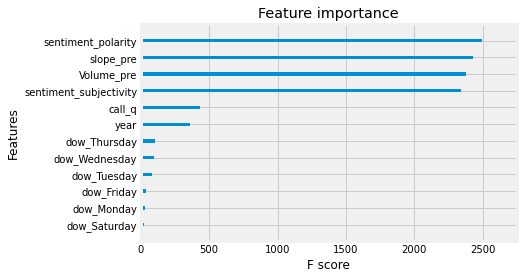

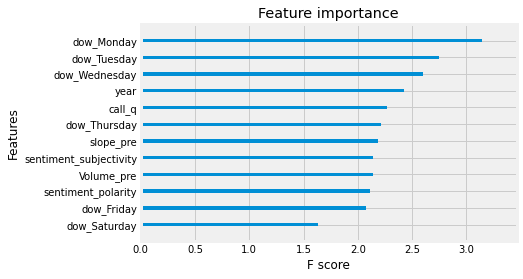

In [531]:
xgb.plot_importance(gbm_final, show_values=False);

xgb.plot_importance(gbm_final, importance_type='gain', show_values=False);

In [533]:
print(f'Proportion of Over 5% growth stocks in the 2021 testing data: {np.mean(y_test):.3f}')
print(f'Proportion of Over 5% growth stocks in the Energy testing data: {np.mean(y_test2):.3f}')
print(f'Proportion of Over 5% growth stocks in the training data: {np.mean(y):.3f}')


Proportion of Over 5% growth stocks in the 2021 testing data: 0.160
Proportion of Over 5% growth stocks in the Energy testing data: 0.314
Proportion of Over 5% growth stocks in the training data: 0.301


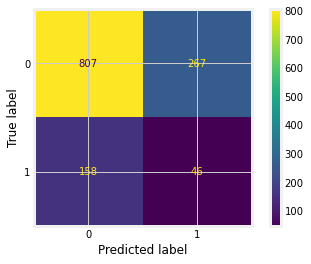

In [534]:
y_predict = gbm.predict(X_test_poly_scaled) 
cm=confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(); 

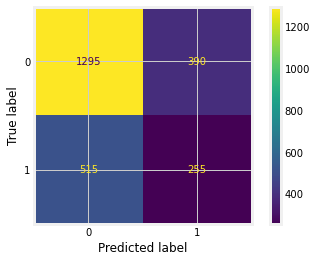

In [535]:
y_predict = gbm.predict(X_test_poly_scaled2) 
cm=confusion_matrix(y_test2, y_predict2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(); 

Average predicted probability: 0.305
Average observed probability: 0.160


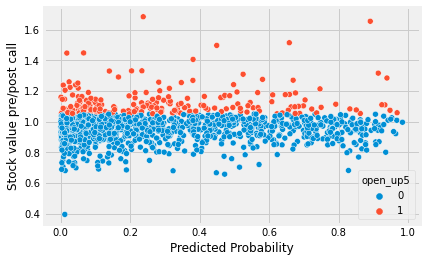

In [488]:
y_proba = gbm.predict_proba(X_test_poly_scaled)[:,1]
print(f'Average predicted probability: {np.mean(y_proba):.3f}')
print(f'Average observed probability: {np.mean(y_test):.3f}')

sns.scatterplot(x=y_proba, y=df['open_ratio'][df.year==2021], hue=y_test)
plt.ylabel('Stock value pre/post call')
plt.xlabel('Predicted Probability');

Average predicted probability: 0.322
Average observed probability: 0.314


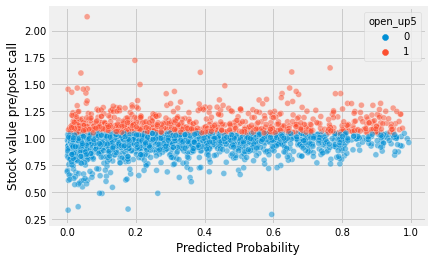

In [537]:
y_proba2 = gbm.predict_proba(X_test_poly_scaled2)[:,1]
print(f'Average predicted probability: {np.mean(y_proba2):.3f}')
print(f'Average observed probability: {np.mean(y_test2):.3f}')

sns.scatterplot(x=y_proba2, y=df2['open_ratio'], hue=y_test2, alpha=0.5)
plt.ylabel('Stock value pre/post call')
plt.xlabel('Predicted Probability');

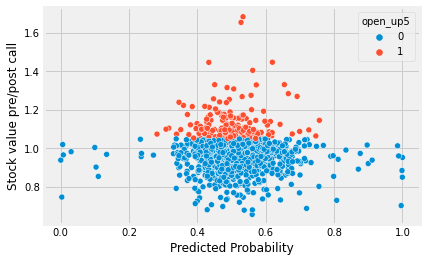

In [414]:
y_proba = m1_log.predict_proba(X_test_poly_scaled)[:,1]

sns.scatterplot(x=y_proba, y=df['open_ratio'][df.year==2021], hue=y_test)
plt.ylabel('Stock value pre/post call')
plt.xlabel('Predicted Probability');

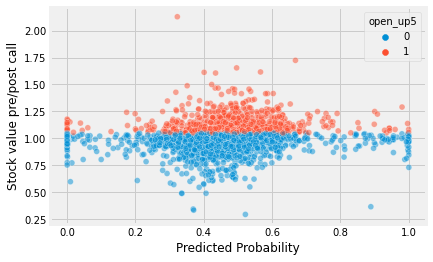

In [538]:
y_proba2 = m1_log.predict_proba(X_test_poly_scaled2)[:,1]

sns.scatterplot(x=y_proba2, y=df2['open_ratio'], hue=y_test2, alpha=0.5)
plt.ylabel('Stock value pre/post call')
plt.xlabel('Predicted Probability');

## <font color='yellow'> Replacing sentiment values with noise: </font>

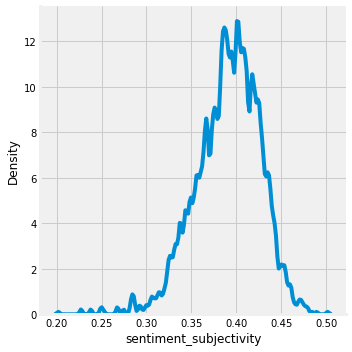

In [570]:
df2.sentiment_subjectivity.describe()
# mean        0.390723
# std         0.035653
# min         0.202048
# 25%         0.368430
# 50%         0.393592
# 75%         0.416003
# max         0.501407
sns.displot(df2, x="sentiment_subjectivity", kind="kde", bw_adjust=0.2);
df2['rand_subj'] = np.random.normal(np.mean(df.sentiment_subjectivity), np.std(df.sentiment_subjectivity))

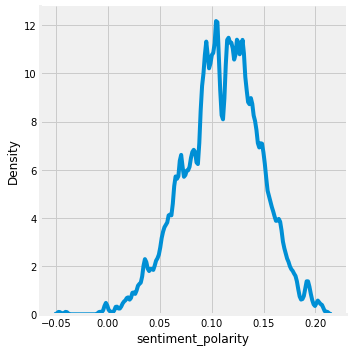

In [571]:
df2.sentiment_polarity.describe()
# mean        0.109965
# std         0.036719
# min        -0.046819
# 25%         0.086899
# 50%         0.111745
# 75%         0.134793
# max         0.211070
sns.displot(df2, x="sentiment_polarity", kind="kde", bw_adjust=0.2);
df2['rand_polar'] = np.random.normal(np.mean(df.sentiment_polarity), np.std(df.sentiment_polarity))

In [572]:
# For Energy set:
X_test2_1 = df2.loc[:,['Volume_pre', 'Dividends_pre', 'year', 'dow_Monday', 'dow_Tuesday', 
              'dow_Wednesday', 'dow_Thursday', 'dow_Friday', 'dow_Saturday', 'slope_pre', 'rand_polar',
              'rand_subj', 'call_q']]
X_test2_1.rename(columns={"rand_subj": "sentiment_subjectivity", "rand_polar": "sentiment_polarity"}, inplace=True)
X_test_poly2_1 = poly.fit_transform(X_test2_1)
X_test_poly_scaled2_1 = scaler.transform(X_test_poly2_1)

# For 2021 set:
df['rand_polar'] = np.random.normal(np.mean(df.sentiment_polarity), np.std(df.sentiment_polarity))
df['rand_subj'] = np.random.normal(np.mean(df.sentiment_polarity), np.std(df.sentiment_polarity))
X_test2_2 = df.loc[:,['Volume_pre', 'Dividends_pre', 'year', 'dow_Monday', 'dow_Tuesday', 
              'dow_Wednesday', 'dow_Thursday', 'dow_Friday', 'dow_Saturday', 'slope_pre', 'rand_polar',
              'rand_subj', 'call_q']][df.year==2021]
X_test2_2.rename(columns={"rand_subj": "sentiment_subjectivity", "rand_polar": "sentiment_polarity"}, inplace=True)
X_test_poly2_2 = poly.fit_transform(X_test2_2)
X_test_poly_scaled2_2 = scaler.transform(X_test_poly2_2)

In [639]:
# For 2021 set with random sentiment:
y_predict2_2 = gbm.predict(X_test_poly_scaled2_2) 
    
print(f'Precision: {precision_score(y_test, y_predict2_2):.3f}')
print(f'Recall:    {recall_score(y_test, y_predict2_2):.3f}')
print(f'F1:        {f1_score(y_test, y_predict2_2):.3f}')
print(f'AUC:       {roc_auc_score(y_test, gbm.predict_proba(X_test_poly_scaled2_2)[:, 1]):.3f}')

Precision: 0.194
Recall:    0.064
F1:        0.096
AUC:       0.535


In [640]:
# For Energy set with random sentiment:
y_predict2_1 = gbm.predict(X_test_poly_scaled2_1) 
    
print(f'Precision: {precision_score(y_test2, y_predict2_1):.3f}')
print(f'Recall:    {recall_score(y_test2, y_predict2_1):.3f}')
print(f'F1:        {f1_score(y_test2, y_predict2_1):.3f}')
print(f'AUC:       {roc_auc_score(y_test2, gbm.predict_proba(X_test_poly_scaled2_1)[:, 1]):.3f}')

Precision: 0.425
Recall:    0.209
F1:        0.280
AUC:       0.582


In [629]:
y_predict = gbm_final.predict(X_test) 
y_predict2 = gbm_final.predict(X_test2) 
y_predict2_1 = gbm_final.predict(X_test2_1) 
y_predict2_2 = gbm_final.predict(X_test2_2) 

print('Energy Original:')
print(f'Precision: {precision_score(y_test2, y_predict2):.3f}')
print(f'Recall:    {recall_score(y_test2, y_predict2):.3f}')
print(f'F1:        {f1_score(y_test2, y_predict2):.3f}')
print(f'AUC:       {roc_auc_score(y_test2, gbm_final.predict_proba(X_test2)[:, 1]):.3f}\n\n')

print('Energy with noise:')
print(f'Precision: {precision_score(y_test2, y_predict2_1):.3f}')
print(f'Recall:    {recall_score(y_test2, y_predict2_1):.3f}')
print(f'F1:        {f1_score(y_test2, y_predict2_1):.3f}')
print(f'AUC:       {roc_auc_score(y_test2, gbm_final.predict_proba(X_test2_1)[:, 1]):.3f}\n\n')


print('2021 Original:')
print(f'Precision: {precision_score(y_test, y_predict):.3f}')
print(f'Recall:    {recall_score(y_test, y_predict):.3f}')
print(f'F1:        {f1_score(y_test, y_predict):.3f}')
print(f'AUC:       {roc_auc_score(y_test, gbm_final.predict_proba(X_test)[:, 1]):.3f}\n\n')

print('2021 with noise:')
print(f'Precision: {precision_score(y_test, y_predict2_2):.3f}')
print(f'Recall:    {recall_score(y_test, y_predict2_2):.3f}')
print(f'F1:        {f1_score(y_test, y_predict2_2):.3f}')
print(f'AUC:       {roc_auc_score(y_test, gbm_final.predict_proba(X_test2_2)[:, 1]):.3f}')

Energy Original:
Precision: 0.395
Recall:    0.331
F1:        0.360
AUC:       0.576


Energy with noise:
Precision: 0.380
Recall:    0.414
F1:        0.396
AUC:       0.565


2021 Original:
Precision: 0.168
Recall:    0.279
F1:        0.210
AUC:       0.552


2021 with noise:
Precision: 0.186
Recall:    0.284
F1:        0.225
AUC:       0.558


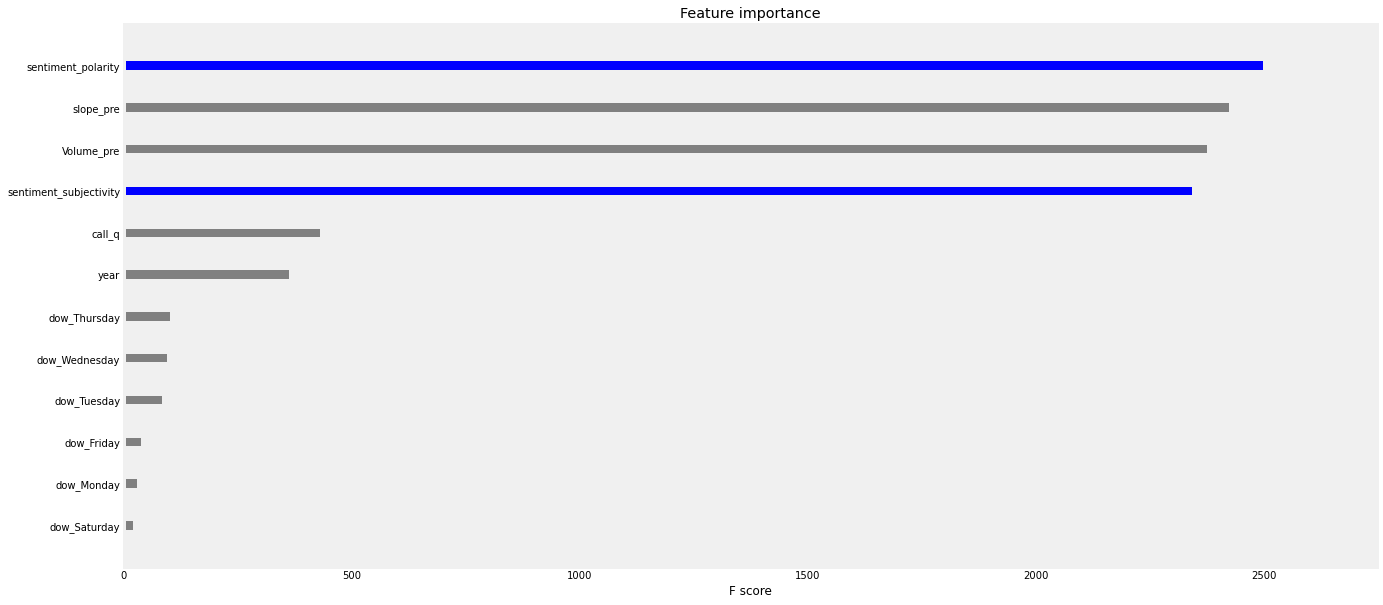

In [626]:
fig, ax = plt.subplots(figsize=[20,10])
xgb.plot_importance(gbm_final, show_values=False, ax=ax, grid=False, 
                    color=['gray', 'gray', 'gray', 'gray',
                          'gray', 'gray', 'gray', 'gray',
                          'blue', 'gray', 'gray', 'blue'])
plt.ylabel('')
plt.savefig('feature_importance.png');

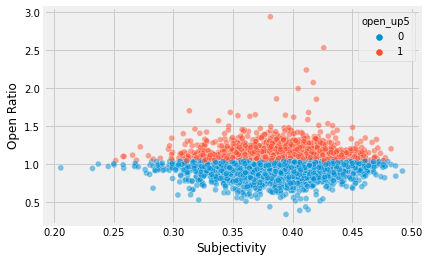

In [645]:
sns.scatterplot(x=df['sentiment_subjectivity'][df['sentiment_subjectivity']>0.1], y=df['open_ratio'], hue=df['open_up5'], alpha=0.5)
plt.ylabel('Open Ratio')
plt.xlabel('Subjectivity');

In [648]:
np.corrcoef(df['sentiment_subjectivity'][df['sentiment_subjectivity']>0.1], df['open_ratio'][df['sentiment_subjectivity']>0.1])

array([[1.        , 0.02649688],
       [0.02649688, 1.        ]])

In [651]:
df.columns

Index(['tick', 'Open_pre', 'High_pre', 'Low_pre', 'Close_pre', 'Volume_pre',
       'Dividends_pre', 'Stock Splits_pre', 'slope_pre', 'date', 'call_q',
       'id', 'Dividends', 'Stock Splits', 'Adj Close', 'Adj Close_post',
       'Adj Close_pre', 'sentiment_polarity', 'sentiment_subjectivity',
       'open_ratio', 'open_up5', 'date2', 'year', 'dow_Friday', 'dow_Monday',
       'dow_Saturday', 'dow_Sunday', 'dow_Thursday', 'dow_Tuesday',
       'dow_Wednesday'],
      dtype='object')

In [653]:
np.corrcoef(df['sentiment_polarity'], df['open_ratio'])

array([[1.        , 0.04321539],
       [0.04321539, 1.        ]])